### Modeling


In [1]:
#import the required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


#import sklearn libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (FunctionTransformer, OneHotEncoder, OrdinalEncoder, StandardScaler)
from sklearn.ensemble import RandomForestClassifier

#folder manager

import os

In [4]:
loan_df = pd.read_csv('data/loan_data.csv')
# load in data set

In [5]:
loan_df.head()


,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


# 1. Dataset Cleaning based off EDA

In [6]:
loan_df = loan_df.drop(columns = ['person_age', 'loan_int_rate', 'loan_percent_income'])
loan_df = loan_df[loan_df['person_emp_exp'] <= 60]
loan_df['loan_status'] = loan_df['loan_status'].map({1: 0, 0: 1}) # since we want to look at defaults, switching defaults to be 1



- **Protected Characteristic:**  
  Under the Equal Credit Opportunity Act, age is a protected class lenders cannot use it to deny or price credit. Hence, age will be dropped from the features.

`Refrence`: https://www.consumerfinance.gov/ask-cfpb/can-a-card-issuer-consider-my-age-when-deciding-whether-to-issue-a-credit-card-to-me-en-20/#:~:text=Under%20the%20Equal%20Credit%20Opportunity,used%20in%20the%20applicant's%20favor

- Dropped columns 'loan_int_rate' and 'loan_percent_income' to avoid data leakage.
- Dropped outliers found in 'person_emp_exp'
- 
### max experince years in the data is 120 right. 
### drop experince above 60 Refrence: https://www.guardianlife.com/retirement/average-age

- **IMPORTANT NOTICE WE SWITCHED DEFAULTS TO BE 1 HERE**


In [7]:
loan_df.head()

,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,3.0,561,No,0
1,female,High School,12282.0,0,OWN,1000.0,EDUCATION,2.0,504,Yes,1
2,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,3.0,635,No,0
3,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,2.0,675,No,0
4,male,Master,66135.0,1,RENT,35000.0,MEDICAL,4.0,586,No,0


### Logistic Modeling


In [8]:
X = loan_df.drop(columns='loan_status')
y = loan_df['loan_status']

In [9]:
cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [10]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
    ]
)

In [11]:
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('logreg', LogisticRegression(max_iter=1000))
])

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [13]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['person_income',
                                                   'person_emp_exp',
                                                   'loan_amnt',
                                                   'cb_person_cred_hist_length',
                                                   'credit_score']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['person_gender',
                                                   'person_education',
                                                   'person_home_ownership',
                                                   'loan_intent',
                                                   'previous_loan_defaults_on_file'])])),
                ('logreg', LogisticRegression(max_iter=1000))])

In [14]:
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

In [15]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print metrics
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"Accuracy:  {accuracy:.4f}")
print(f"F1 Score:  {f1:.4f}")

Precision: 0.9145
Recall:    0.9201
Accuracy:  0.8710
F1 Score:  0.9173


In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.70      0.71      2000
           1       0.91      0.92      0.92      6998

    accuracy                           0.87      8998
   macro avg       0.81      0.81      0.81      8998
weighted avg       0.87      0.87      0.87      8998



###  Model Evaluation Summary 

- **Precision (1):** 0.91  
  - When the model predicts a default, it’s correct 91% of the time.

- **Recall (1):** 0.92  
  - The model successfully identifies 92% of all actual defaults.

- **F1 Score (1):** 0.9173 
  - Strong balance between precision and recall for predicting defaults.

- **Accuracy:** 87.1%  
  - Overall correctness across all predictions.

---

###  Minority Class 

- **F1 score:** 0.71  
- Indicates the model is less effective at identifying non-defaults.

In [17]:
y.value_counts(normalize=True)

loan_status
1    0.777728
0    0.222272
Name: proportion, dtype: float64

---

### Class Distribution

- 77.8% of the data are defaults (`loan_status = 1`)  
- 22.2% are non-defaults (`loan_status = 0`)

-------------

In [18]:
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('logreg', LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000))
])

In [195]:
param_grid = {
    'logreg__C': [0.01, 0.05, 0.1, 0.5, 1, 5]
}

In [196]:
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

In [197]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['person_income',
                                                                          'person_emp_exp',
                                                                          'loan_amnt',
                                                                          'cb_person_cred_hist_length',
                                                                          'credit_score']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['person_gender',
                                                                          'person_education',
                                                                          'person_home_ownership',
                                                                          'loan_intent',
                                                                          'previous_loan_defaults_on_file'])])),
                                       ('logreg',
                                        LogisticRegression(max_iter=1000,
                                                           penalty='l1',
                                                           solver='liblinear'))]),
             n_jobs=-1, param_grid={'logreg__C': [0.01, 0.05, 0.1, 0.5, 1, 5]},
             scoring='f1', verbose=1)

In [198]:
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

In [199]:
print("Best C:", grid.best_params_['logreg__C'])
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Best C: 0.01

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.72      0.69      0.70      2000
           1       0.91      0.92      0.92      6998

    accuracy                           0.87      8998
   macro avg       0.81      0.80      0.81      8998
weighted avg       0.87      0.87      0.87      8998

Confusion Matrix:
 [[1370  630]
 [ 536 6462]]


### Logistic Model with C Hyperparameter Evaluation Summary 

- **Precision (1):** 0.91  
  - When the model predicts a default, it’s correct 91% of the time.

- **Recall (1):** 0.92  
  - The model successfully identifies 92% of all actual defaults.

- **F1 Score (1):** 0.92 
  - Strong balance between precision and recall for predicting defaults.

- **Accuracy:** 87.0%  
  - Overall correctness across all predictions.
 
---

###  Minority Class 

- **F1 score:** 0.70  
- Indicates this model is also less effective at identifying non-defaults.

### Conclusion

-  Changing C didn’t improve performance (stayed essentially the same)

In [200]:
# Get categorical feature names
ohe = best_model.named_steps['preprocess'].named_transformers_['cat']
encoded_cat_names = ohe.get_feature_names_out(input_features=cat_cols)

# Combine with numeric column names
all_feature_names = np.concatenate([num_cols, encoded_cat_names])

# Get the coefficients from the fitted logistic regression
logreg = best_model.named_steps['logreg']
coefs = logreg.coef_[0]

# Build dataframe of non-zero coefficients
feature_importance = pd.DataFrame({
    'feature': all_feature_names,
    'coefficient': coefs
}).query('coefficient != 0').sort_values(by='coefficient', key=abs, ascending=False)

# Show top 10 most important features
feature_importance.head(10)

,feature,coefficient
18,previous_loan_defaults_on_file_Yes,5.063943
0,person_income,1.062871
12,person_home_ownership_RENT,-0.832783
17,loan_intent_VENTURE,0.583672
2,loan_amnt,-0.574957
13,loan_intent_EDUCATION,0.458472
4,credit_score,0.349424
16,loan_intent_PERSONAL,0.249142
11,person_home_ownership_OWN,0.172547


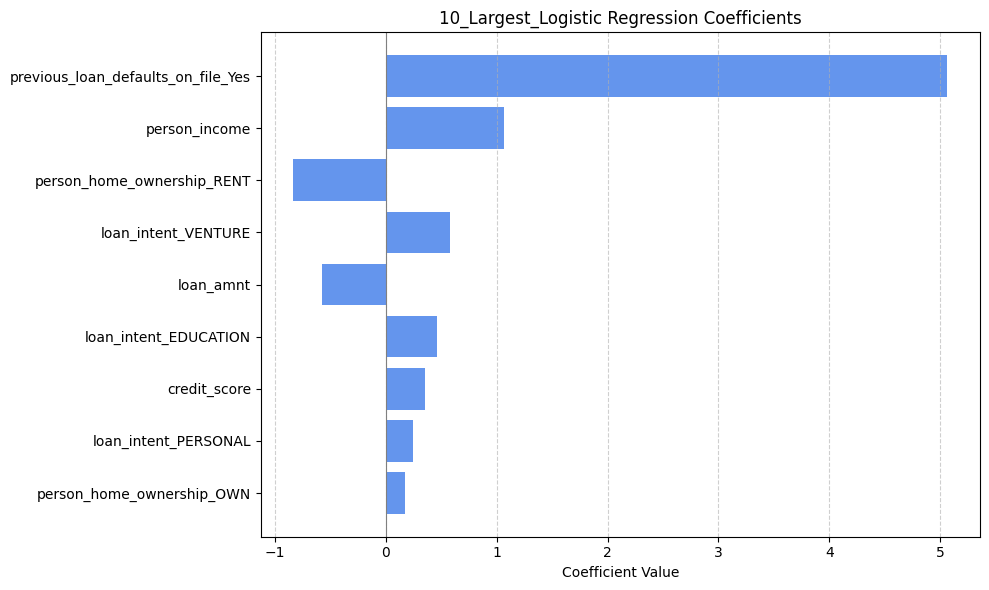

In [205]:
plot_features = feature_importance.head(10)

plt.figure(figsize=(10, 6))
bars = plt.barh(plot_features['feature'], plot_features['coefficient'], color='cornflowerblue')

plt.axvline(x=0, color='gray', linewidth=0.8)
plt.xlabel("Coefficient Value")
plt.title("10_Largest_Logistic Regression Coefficients")
plt.gca().invert_yaxis() 
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()

plt.savefig("graphs/10_Largest_Logistic_Regression_Coefficients.png", dpi=300)

###  Logistic Regression Coefficients

| Feature                             | Coefficient | Interpretation |
|-------------------------------------|-------------|----------------|
| previous_loan_defaults_on_file_Yes | **+5.06**    | Strongest predictor of default — having a prior default increases the odds substantially. |
| person_income                       | **+1.06**    | Higher income is associated with a higher chance of default (possibly counterintuitive; may reflect riskier borrowers with high reported income). |
| person_home_ownership_RENT         | **−0.83**    | Renters are less likely to default compared to the baseline category (possibly due to underwriting bias or data pattern). |
| loan_intent_VENTURE                | **+0.58**    | Loans intended for ventures carry higher default risk. |
| loan_amnt                           | **−0.57**    | Higher loan amounts are associated with lower default probability — potentially indicating trust in high-quality borrowers. |
| loan_intent_EDUCATION              | **+0.46**    | Educational loans tend to have higher default risk. |
| credit_score                        | **+0.35**    | Surprisingly positive; could be due to correlation with other riskier variables or multicollinearity. |
| loan_intent_PERSONAL               | **+0.25**    | Personal loan intents carry elevated risk of default. |
| person_home_ownership_OWN          | **+0.17**    | Homeowners (vs. baseline group) show slightly higher default risk in this model. |

--------

In [202]:
# Random forest pipeline
rf_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
])

rf_pipeline.fit(X_train, y_train)

y_pred_rf = rf_pipeline.predict(X_test)
y_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.68      0.75      2000
           1       0.91      0.96      0.94      6998

    accuracy                           0.90      8998
   macro avg       0.87      0.82      0.84      8998
weighted avg       0.89      0.90      0.89      8998



### Random Forest Evaluation Summary 

- **Precision (1):** 0.91  
  - When the model predicts a default, it’s correct 91% of the time.

- **Recall (1):** 0.96  
  - The model successfully identifies 92% of all actual defaults.

- **F1 Score (1):** 0.94 
  - Strong balance between precision and recall for predicting defaults.

- **Accuracy:** 90.0%  
  - Overall correctness across all predictions.



In [203]:
# Step 1: Get categorical feature names from the encoder
ohe = rf_pipeline.named_steps['preprocess'].named_transformers_['cat']
encoded_cat_names = ohe.get_feature_names_out(input_features=cat_cols)

# Step 2: Combine with numeric column names
all_feature_names = np.concatenate([num_cols, encoded_cat_names])

# Step 3: Extract feature importances from the Random Forest
rf_model = rf_pipeline.named_steps['rf']
importances = rf_model.feature_importances_

# Step 4: Create and sort DataFrame
rf_feature_importance = pd.DataFrame({
    'feature': all_feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Step 5: Show top 10
rf_feature_importance.head(10)

,feature,importance
18,previous_loan_defaults_on_file_Yes,0.263732
0,person_income,0.226218
2,loan_amnt,0.141750
4,credit_score,0.106570
1,person_emp_exp,0.058483
12,person_home_ownership_RENT,0.054913
3,cb_person_cred_hist_length,0.051361
5,person_gender_male,0.013536
14,loan_intent_HOMEIMPROVEMENT,0.010442
6,person_education_Bachelor,0.010359


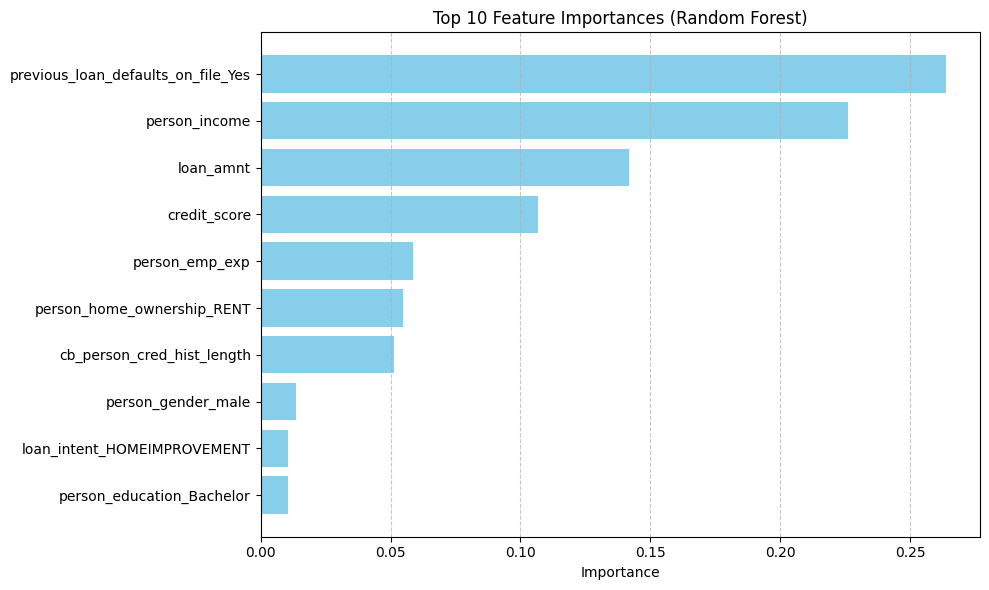

In [217]:
# Code for top 10 features

top_features = rf_feature_importance.head(10)

plt.figure(figsize=(10, 6))
plt.barh(top_features['feature'], top_features['importance'], color='skyblue')
plt.xlabel("Importance")
plt.title(f"Top 10 Feature Importances (Random Forest)")
plt.gca().invert_yaxis()  # Highest importance at top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.savefig("graphs/random_forest_feature_importance.png", dpi=300)

In [19]:
#convert to data frame

model_results = pd.DataFrame({
    'Model': ['Vanilla Logistic', 'L1-Tuned Logistic (C=0.01)', 'Random Forest'],
    'F1 Score (Defaults)': [0.9173, 0.92, 0.94],
    'Recall (Defaults)': [0.92, 0.92, 0.96],
    'Precision (Defaults)': [0.91, 0.91, 0.91],
    'Accuracy': [0.87, 0.87, 0.89]
})

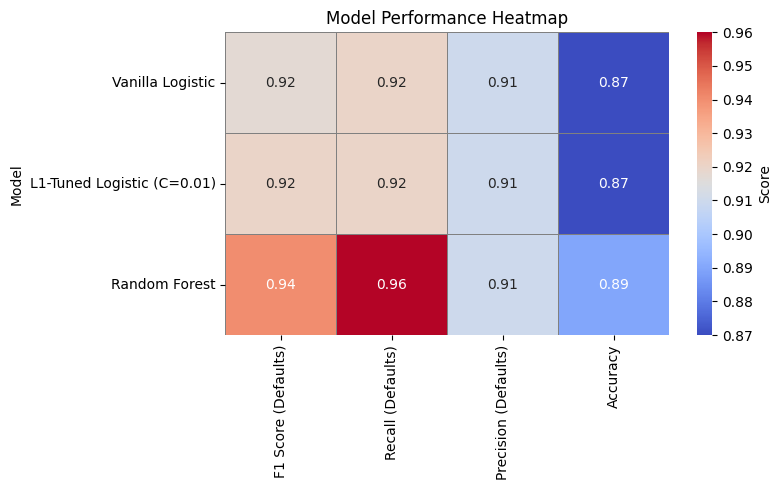

In [20]:
#Create a map

heatmap_data = model_results.set_index('Model')

plt.figure(figsize=(8, 5))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",  # you can change this to 'coolwarm', 'viridis', etc.
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Score'}
)

plt.title("Model Performance Heatmap")
plt.tight_layout()

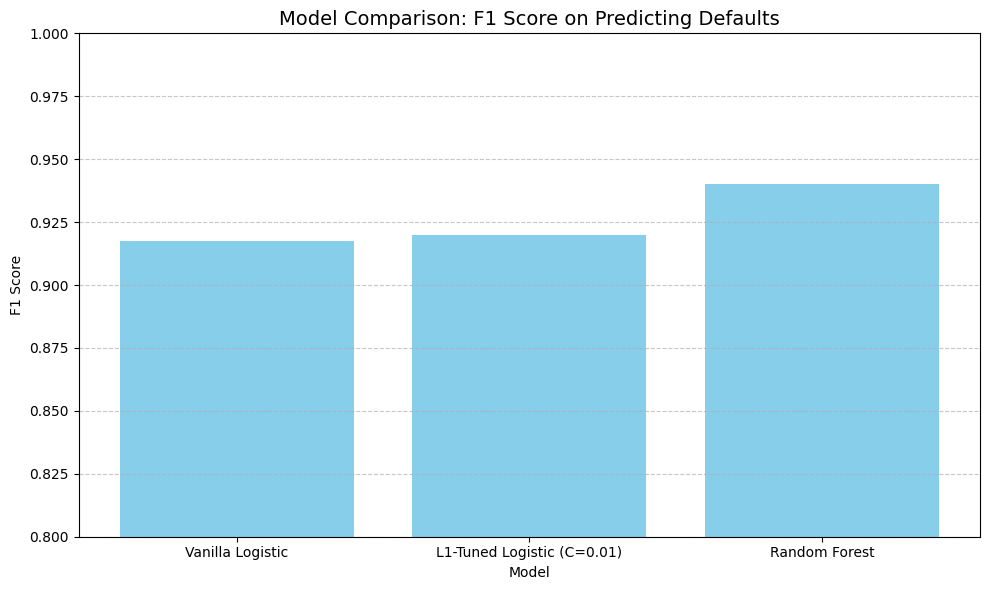

In [21]:
#Model comparison plot

plt.figure(figsize=(10, 6))
plt.bar(model_results['Model'], model_results['F1 Score (Defaults)'], color='skyblue')
plt.ylim(0.8, 1)
plt.title("Model Comparison: F1 Score on Predicting Defaults", fontsize=14)
plt.ylabel("F1 Score")
plt.xlabel("Model")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

### Conclusion
- The Random Forest model is more accurate than our Logistic Regression model; however, it is far less interpretable.
- We recommend using the models as appropriate: Logistic Regression for interpretability, and Random Forest for predictive accuracy.